In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from keras.models import Model, Sequential, load_model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [ ]:
def show_mult_img(rows, columns, img_names, vmin=0, vmax=255):
    """
    Displays multiple images in a grid using Matplotlib subplots.

    Args:
        rows (int): Number of rows in the grid.
        columns (int): Number of columns in the grid.
        img_names (list): A list of image data to be displayed.
        vmin (float/int): Minimum value of the colormap range. Default is 0.
        vmax (float/int): Maximum value of the colormap range. Default is 255.

    Returns:
        None
    """
    fig = plt.figure(figsize=(15, 17), dpi=100)
    for i in range(len(img_names)):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img_names[i], cmap='gray', vmin=vmin, vmax=vmax)
        plt.axis('off')
        plt.title('img_' + str(i))

In [ ]:
def prepration(image_file):
  # opening image and resizing
  image = np.array((Image.open(image_file)).resize((64,64)))

  # adjusting the brightness and contrast
  gamma_value = 0.4
  gamma = np.uint8(((image/255)**gamma_value)*255)

  # Denoising
  medianimage = cv2.medianBlur(gamma, 3)

  return medianimage



In [ ]:
# Mounting Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/datasets'

/content/drive/My Drive/datasets


In [ ]:
import os
import cv2

dataset_path = '/content/drive/My Drive/datasets/celeba/images'  # Update with your dataset path
image_files = os.listdir(dataset_path)


celeb = []
for path in image_files:
    if '.jpg' in path:
        celeb.append(os.path.join(dataset_path, path))

In [ ]:
len(celeb)

90034

In [ ]:
images = []

for i in range(1000):
  prepared = prepration(celeb[i])
  images.append(prepared)



images = np.array(images)

In [ ]:
images.shape

(1000, 64, 64, 3)

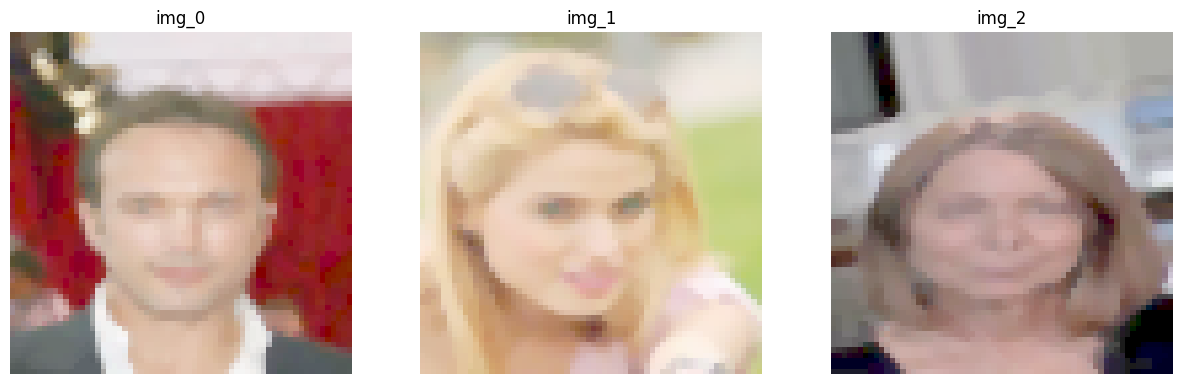

In [ ]:
show_mult_img(1, 3, (images[100], images[110], images[29]))

In [ ]:
train_data=images

In [ ]:
train_data.shape

(1000, 64, 64, 3)

In [ ]:
def define_discriminator(image_shape=(64, 64, 3)):
    model = Sequential()

    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same', input_shape=image_shape))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0002)
    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

discr = define_discriminator()
print(discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [ ]:
def define_generator(latent_dim, channels=3):
    model = Sequential()

    model.add(Dense(16 * 16 * 128, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((16, 16, 128)))

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(channels, (8, 8), activation='tanh', padding='same'))

    return model

gen = define_generator(100)
print(gen.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             3309568   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 128)      262272    
 ranspose)                                            

In [ ]:
def define_gan(generator, discriminator):
  discriminator.trainable = False

  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  opt = Adam(lr=0.0001)
  model.compile(loss = 'binary_crossentropy', optimizer =opt, metrics=['accuracy'])

  return model

In [ ]:
def load_real_samples():
  X_train = train_data
  X = X_train.astype('float32')

  X = (X-127.5)/127.5

  return X

In [ ]:
def generate_real_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, 1))

  return X, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):
  X_input = randn(latent_dim*n_samples)
  X_input = X_input.reshape(n_samples, latent_dim)

  return X_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
  X_input = generate_latent_points(latent_dim, n_samples)
  X = generator.predict(X_input)
  y = zeros((n_samples, 1 ))
  return X, y

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128 ):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  #bat_per_epo = 100 # for time

  half_batch = int(n_batch / 2)

  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake  = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)


      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))

      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      print(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss)

  g_model.save('/content/drive/MyDrive/Models/ganE100L1000.h5')

In [ ]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=100)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 3s 1s/step
1 1 7 0.6395809650421143 0.6967474222183228 [0.6892820000648499, 1.0]
2/2 [==============================] - 6s 3s/step
1 2 7 0.444102019071579 0.7037357091903687 [0.6816822290420532, 1.0]
2/2 [==============================] - 3s 1s/step
1 3 7 0.3038237690925598 0.7168482542037964 [0.6680315732955933, 1.0]
2/2 [==============================] - 3s 1s/step
1 4 7 0.19369661808013916 0.7385883331298828 [0.6469869613647461, 1.0]
2/2 [==============================] - 3s 1s/step
1 5 7 0.13009794056415558 0.7678829431533813 [0.6196950674057007, 1.0]
2/2 [==============================] - 4s 2s/step
1 6 7 0.0751069039106369 0.808357834815979 [0.5898416042327881, 1.0]
2/2 [==============================] - 4s 2s/step
1 7 7 0.04965001717209816 0.8495155572891235 [0.5573176145553589, 1.0]
2/2 [==============================] - 3s 1s/step
2 1 7 0.031963903456926346 0.8992459774017334 [0.528410792350769, 1.0]
2/2 [==============================] -

100 7 7 0.34257638454437256 0.2875217795372009 [1.560129165649414, 0.0234375]


In [ ]:
def show_plot(examples, n ):
  for i in range(n*n):
    plt.subplot(n, n , i + 1)
    plt.axis('off')
    plt.imshow(examples[i, :, :, :])
  plt.show()

1/1 [==============================] - 1s 1s/step


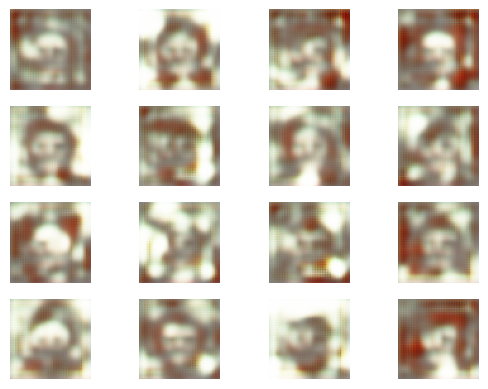

In [ ]:
model = load_model('/content/drive/My Drive/Models/ganE100L1000.h5')
latent_points = generate_latent_points(100, 16)
X = model.predict(latent_points)
X = (X + 1) / 2

import numpy as np
X = (X*255).astype(np.uint8)


show_plot(X, 4)